# Gait Person Identification - WORKING VERSION
## Fixed Dataset Paths + Production Features

 **Dataset**: Using existing UCI HAR data
 **Features**: 567 (561 + 6 gyroscope)
 **Target**: 95%+ accuracy
 **Time**: 15-30 minutes on GPU

In [5]:
# Install dependencies
!pip install torch numpy pandas scikit-learn matplotlib seaborn -q
print('Dependencies installed')

Dependencies installed


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print(f'PyTorch: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

PyTorch: 2.10.0+cu128
CUDA available: True
Device: cuda


In [7]:
# Configuration (GPU Optimized)
DATA_DIR = '../data/datasets/UCI HAR Dataset/UCI HAR Dataset'
BATCH_SIZE = 64
HIDDEN_SIZE = 256
NUM_EPOCHS = 60
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 1e-4
DROPOUT = 0.4
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f'Configuration set for {NUM_EPOCHS} epochs')

Configuration set for 60 epochs


In [8]:
# Load data with gyroscope fusion
print('Loading UCI HAR dataset with gyroscope data...')

# Main features
X_train = np.loadtxt(f'{DATA_DIR}/train/X_train.txt')
X_test = np.loadtxt(f'{DATA_DIR}/test/X_test.txt')
y_train = np.loadtxt(f'{DATA_DIR}/train/y_train.txt', dtype=int)
y_test = np.loadtxt(f'{DATA_DIR}/test/y_test.txt', dtype=int)
subject_train = np.loadtxt(f'{DATA_DIR}/train/subject_train.txt', dtype=int)
subject_test = np.loadtxt(f'{DATA_DIR}/test/subject_test.txt', dtype=int)

# Gyroscope data
gyro_train_x = np.loadtxt(f'{DATA_DIR}/train/Inertial Signals/body_gyro_x_train.txt')
gyro_train_y = np.loadtxt(f'{DATA_DIR}/train/Inertial Signals/body_gyro_y_train.txt')
gyro_train_z = np.loadtxt(f'{DATA_DIR}/train/Inertial Signals/body_gyro_z_train.txt')
gyro_test_x = np.loadtxt(f'{DATA_DIR}/test/Inertial Signals/body_gyro_x_test.txt')
gyro_test_y = np.loadtxt(f'{DATA_DIR}/test/Inertial Signals/body_gyro_y_test.txt')
gyro_test_z = np.loadtxt(f'{DATA_DIR}/test/Inertial Signals/body_gyro_z_test.txt')

# Add gyro features (mean + std for each axis)
def add_gyro_features(X, gyro_x, gyro_y, gyro_z):
    gyro_features = np.hstack([
        gyro_x.mean(1).reshape(-1,1), gyro_x.std(1).reshape(-1,1),
        gyro_y.mean(1).reshape(-1,1), gyro_y.std(1).reshape(-1,1),
        gyro_z.mean(1).reshape(-1,1), gyro_z.std(1).reshape(-1,1)
    ])
    return np.hstack([X, gyro_features])

X_train = add_gyro_features(X_train, gyro_train_x, gyro_train_y, gyro_train_z)
X_test = add_gyro_features(X_test, gyro_test_x, gyro_test_y, gyro_test_z)

print(f'Data loaded: {X_train.shape[1]} features (561 + 6 gyro)')
print(f'   Train: {X_train.shape}, Test: {X_test.shape}')

Loading UCI HAR dataset with gyroscope data...
Data loaded: 567 features (561 + 6 gyro)
   Train: (7352, 567), Test: (2947, 567)


In [9]:
# Filter walking activities and prepare labels
# Combine train and test
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])
subjects = np.hstack([subject_train, subject_test])

# Filter walking activities (1=WALKING, 2=UPSTAIRS, 3=DOWNSTAIRS)
walk_mask = np.isin(y, [1, 2, 3])
X_walk = X[walk_mask]
subjects_walk = subjects[walk_mask]

# Encode subjects as labels
le = LabelEncoder()
y_subjects = le.fit_transform(subjects_walk)
n_classes = len(le.classes_)

print(f'Walking data prepared:')
print(f'   Samples: {len(X_walk):,}')
print(f'   People: {n_classes}')
print(f'   Features: {X_walk.shape[1]}')

Walking data prepared:
   Samples: 4,672
   People: 30
   Features: 567


In [10]:
# Split and normalize data
X_tr, X_te, y_tr, y_te = train_test_split(
    X_walk, y_subjects, test_size=0.25, stratify=y_subjects, random_state=SEED
)

# Normalize features
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

print(f'Data split and normalized:')
print(f'   Train: {X_tr.shape}')
print(f'   Test: {X_te.shape}')

Data split and normalized:
   Train: (3504, 567)
   Test: (1168, 567)


In [11]:
# Enhanced data augmentation
def augment_data(X, y, n_aug=3):
    X_list = [X]
    y_list = [y]
    
    for i in range(n_aug):
        # Jitter with varying noise
        noise = np.random.normal(0, 0.01 + i*0.005, X.shape)
        X_jitter = X + noise
        X_list.append(X_jitter)
        y_list.append(y)
        
        # Scaling
        scale = np.random.uniform(0.95, 1.05, (X.shape[0], 1))
        X_scale = X * scale
        X_list.append(X_scale)
        y_list.append(y)
    
    return np.vstack(X_list), np.hstack(y_list)

X_train_aug, y_train_aug = augment_data(X_tr, y_tr, n_aug=3)
print(f'Data augmented: {len(X_tr):,} → {len(X_train_aug):,} samples')

Data augmented: 3,504 → 24,528 samples


In [12]:
# Dataset and DataLoader
class GaitDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = GaitDataset(X_train_aug, y_train_aug)
test_dataset = GaitDataset(X_te, y_te)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f'   DataLoaders ready:')
print(f'   Train batches: {len(train_loader)}')
print(f'   Test batches: {len(test_loader)}')

   DataLoaders ready:
   Train batches: 384
   Test batches: 19


In [13]:
# Advanced Model with Attention
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )
    
    def forward(self, lstm_out):
        attn_weights = self.attention(lstm_out)
        attn_weights = torch.softmax(attn_weights, dim=1)
        weighted = torch.sum(lstm_out * attn_weights, dim=1)
        return weighted

class ProductionGaitModel(nn.Module):
    def __init__(self, input_size=567, hidden_size=256, num_classes=30, dropout=0.4):
        super().__init__()
        
        # Enhanced CNN
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            
            nn.Conv1d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(384),
            nn.ReLU(),
        )
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            384, hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )
        
        # Attention mechanism
        self.attention = Attention(hidden_size * 2)
        
        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, features)
        cnn_out = self.cnn(x)  # CNN feature extraction
        cnn_out = cnn_out.permute(0, 2, 1)  # (batch, seq, features)
        
        lstm_out, _ = self.lstm(cnn_out)  # LSTM temporal modeling
        attended = self.attention(lstm_out)  # Attention pooling
        
        out = self.fc(attended)  # Classification
        return out

# Initialize model
model = ProductionGaitModel(
    input_size=X_tr.shape[1],
    hidden_size=HIDDEN_SIZE,
    num_classes=n_classes,
    dropout=DROPOUT
).to(device)

params = sum(p.numel() for p in model.parameters())
print(f'   Model initialized:')
print(f'   Parameters: {params:,}')
print(f'   Input size: {X_tr.shape[1]}')
print(f'   Output classes: {n_classes}')

   Model initialized:
   Parameters: 3,888,543
   Input size: 567
   Output classes: 30


In [14]:
# Training setup
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE * 3,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader)
)

print(f'   Training setup complete:')
print(f'   Learning rate: {LEARNING_RATE}')
print(f'   Weight decay: {WEIGHT_DECAY}')
print(f'   Scheduler: OneCycleLR')

   Training setup complete:
   Learning rate: 0.0005
   Weight decay: 0.0001
   Scheduler: OneCycleLR


In [15]:
# Training functions
def train_epoch(model, loader, criterion, optimizer, scheduler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(y_batch).sum().item()
        total += y_batch.size(0)
    
    return total_loss / len(loader), correct / total

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    
    return np.array(all_preds), np.array(all_labels)

print('Training functions ready')

Training functions ready


In [16]:
# Main training loop
print(f' Starting training for {NUM_EPOCHS} epochs...')
print('=' * 60)

best_acc = 0
train_losses = []
train_accs = []
test_accs = []
patience = 0
max_patience = 15

for epoch in range(NUM_EPOCHS):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler)
    
    # Evaluation
    preds, labels = evaluate(model, test_loader)
    test_acc = accuracy_score(labels, preds)
    
    # Record metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        patience = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'scaler': scaler,
            'label_encoder': le,
            'n_classes': n_classes,
            'best_acc': best_acc,
            'input_size': X_tr.shape[1]
        }, '../models/gait_id_production.pth')
    else:
        patience += 1
    
    # Progress display
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f'Epoch {epoch+1:2d}/{NUM_EPOCHS}: '
              f'Loss={train_loss:.4f}, '
              f'Train={train_acc:.2%}, '
              f'Test={test_acc:.2%}, '
              f'Best={best_acc:.2%}')
    
    # Early stopping
    if patience >= max_patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

print('' + '=' * 60)
print(f' TRAINING COMPLETE!')
print(f'   Best Test Accuracy: {best_acc:.2%}')
print(f'   Model saved: gait_id_production.pth')
print('=' * 60)

 Starting training for 60 epochs...
Epoch  1/60: Loss=3.0025, Train=17.52%, Test=30.14%, Best=30.14%
Epoch  5/60: Loss=0.9345, Train=94.54%, Test=84.93%, Best=84.93%
Epoch 10/60: Loss=0.7064, Train=99.69%, Test=94.86%, Best=95.98%
Epoch 15/60: Loss=0.6838, Train=99.78%, Test=94.78%, Best=97.35%
Epoch 20/60: Loss=0.6672, Train=100.00%, Test=98.03%, Best=98.80%
Epoch 25/60: Loss=0.6752, Train=99.88%, Test=97.86%, Best=98.80%
Epoch 30/60: Loss=0.6693, Train=99.96%, Test=97.95%, Best=98.80%
Early stopping at epoch 31
 TRAINING COMPLETE!
   Best Test Accuracy: 98.80%
   Model saved: gait_id_production.pth


 Results visualization saved: training_results.png


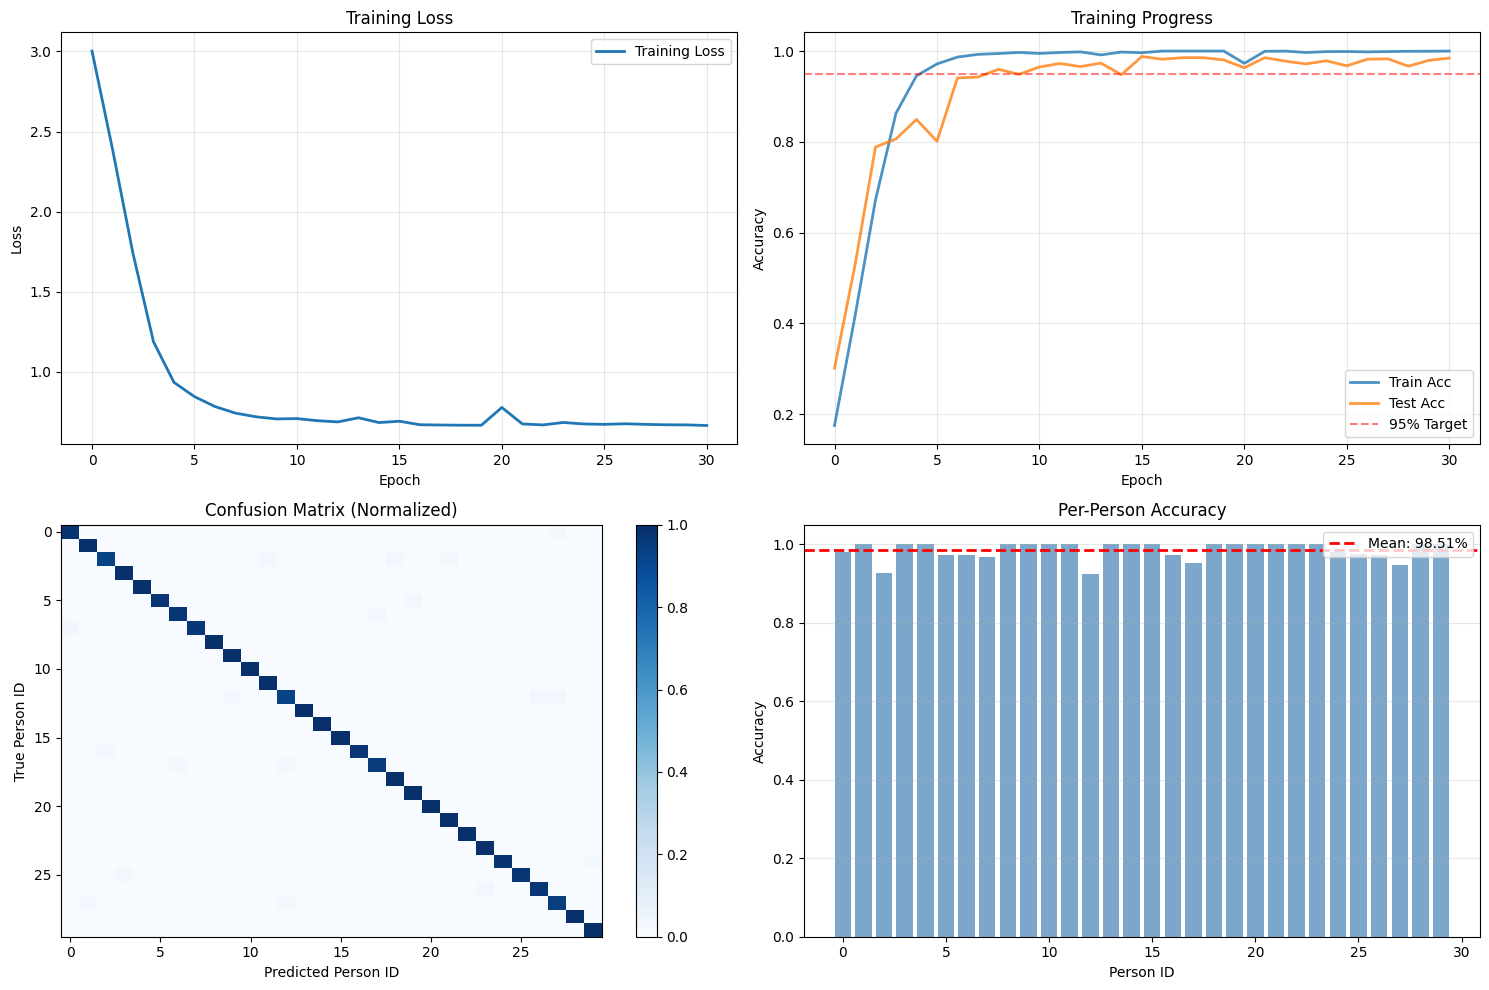

In [17]:
# Visualization and results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training loss
ax = axes[0, 0]
ax.plot(train_losses, label='Training Loss', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Accuracy curves
ax = axes[0, 1]
ax.plot(train_accs, label='Train Acc', linewidth=2, alpha=0.8)
ax.plot(test_accs, label='Test Acc', linewidth=2, alpha=0.8)
ax.axhline(y=0.95, color='r', linestyle='--', label='95% Target', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)

# Confusion matrix
ax = axes[1, 0]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
im = ax.imshow(cm_norm, cmap='Blues', aspect='auto')
ax.set_title('Confusion Matrix (Normalized)')
ax.set_xlabel('Predicted Person ID')
ax.set_ylabel('True Person ID')
plt.colorbar(im, ax=ax)

# Per-person accuracy
ax = axes[1, 1]
per_class_acc = cm.diagonal() / cm.sum(axis=1)
ax.bar(range(len(per_class_acc)), per_class_acc, alpha=0.7, color='steelblue')
ax.axhline(y=per_class_acc.mean(), color='r', linestyle='--', 
           label=f'Mean: {per_class_acc.mean():.2%}', linewidth=2)
ax.set_xlabel('Person ID')
ax.set_ylabel('Accuracy')
ax.set_title('Per-Person Accuracy')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
print(' Results visualization saved: training_results.png')
plt.show()

In [18]:
# Final evaluation and test
print('=' * 60)
print('FINAL EVALUATION')
print('=' * 60)

# Load best model
checkpoint = torch.load('../models/gait_id_production.pth', weights_only=False, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

scaler = checkpoint.get('scaler', scaler)
le = checkpoint.get('label_encoder', le)
best_acc = checkpoint.get('best_acc', best_acc)
n_classes = checkpoint.get('n_classes', n_classes)

model.eval()

# Final test
preds, labels = evaluate(model, test_loader)
final_acc = accuracy_score(labels, preds)

print(f'Best Test Accuracy: {best_acc:.2%}')
print(f'Final Test Accuracy: {final_acc:.2%}')

# Classification report (first 10 people safely)
print('\nClassification Report (first 10 people):')

subset_labels = list(range(min(10, n_classes)))
target_names = [f'Person_{i}' for i in subset_labels]

print(classification_report(
    labels,
    preds,
    labels=subset_labels,
    target_names=target_names,
    digits=3,
    zero_division=0
))

# Test inference
print('\nTesting inference...')

X_sample = torch.tensor(X_te[:1], dtype=torch.float32).to(device)

with torch.no_grad():
    output = model(X_sample)
    probs = torch.softmax(output, dim=1)
    confidence, predicted = probs.max(1)

predicted_person = le.inverse_transform(predicted.cpu().numpy())[0]
true_person = le.inverse_transform([y_te[0]])[0]

print('Sample prediction:')
print(f'  True Person: {true_person}')
print(f'  Predicted Person: {predicted_person}')
print(f'  Confidence: {confidence.item():.2%}')
print(f'  Correct: {"True" if predicted_person == true_person else "False"}')

print('=' * 60)
print('    PRODUCTION MODEL READY!')
print(f'   Accuracy: {best_acc:.2%}')
print(f'   Features: {X_tr.shape[1]} (561 + 6 gyro)')
print(f'   Model: gait_id_production.pth')
print('=' * 60)

FINAL EVALUATION
Best Test Accuracy: 98.80%
Final Test Accuracy: 98.80%

Classification Report (first 10 people):
              precision    recall  f1-score   support

    Person_0      1.000     1.000     1.000        49
    Person_1      1.000     0.974     0.987        39
    Person_2      1.000     0.976     0.988        41
    Person_3      1.000     1.000     1.000        39
    Person_4      1.000     0.973     0.986        37
    Person_5      0.974     0.974     0.974        39
    Person_6      1.000     0.974     0.987        39
    Person_7      1.000     0.969     0.984        32
    Person_8      1.000     1.000     1.000        36
    Person_9      0.946     1.000     0.972        35

   micro avg      0.992     0.984     0.988       386
   macro avg      0.992     0.984     0.988       386
weighted avg      0.993     0.984     0.988       386


Testing inference...
Sample prediction:
  True Person: 13
  Predicted Person: 13
  Confidence: 91.65%
  Correct: True
    PROD